<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I2wUTT12p5bX3RCku_T_82aD4tkY9LVY" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>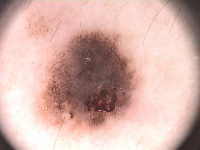</td><td>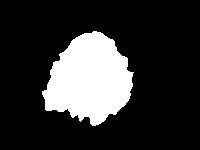</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
# !wget -c https://www.kaggle.com/datasets/kanametov/ph2dataset/PH2Dataset/

# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

--2023-12-08 11:37:31--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.13.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.13.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2023-12-08 11:37:31--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc75c9d490c9886ec31f9414ad4c.dl.dropboxusercontent.com/cd/0/inline/CJBO09IN-w6e5sEKoP5N2SH-jodq6QkGPvgzU5NiydBIn0InOk524C1ceRYRPanT-h7EsV0fIrc1VhhY7ONQymCpTBipbizVYTr7RZfgEa3p4tzbyrfX4OxPzc4uraWxIHs/file# [following]
--2023-12-08 11:37:32--  https://uc75c9d490c9886ec31f9414ad4c.dl.dropboxusercontent.com/cd/0/inline/CJBO09IN-w6e5sEKoP5N2SH-jodq6QkGPvgzU5NiydBIn0InOk524C1ceRYRPanT-h7EsV0fIrc1VhhY7ONQymCpTBipbizVYTr7RZfgEa3p4tzbyr

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls

drive  PH2Dataset  PH2Dataset.rar  sample_data


In [4]:
get_ipython().system_raw("unrar x /content/drive/MyDrive/PH2Dataset.rar")
# !unzip -q /content/gdrive/MyDrive/PH2Dataset.rar

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [5]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2_Dataset')):

    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [6]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [7]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [8]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

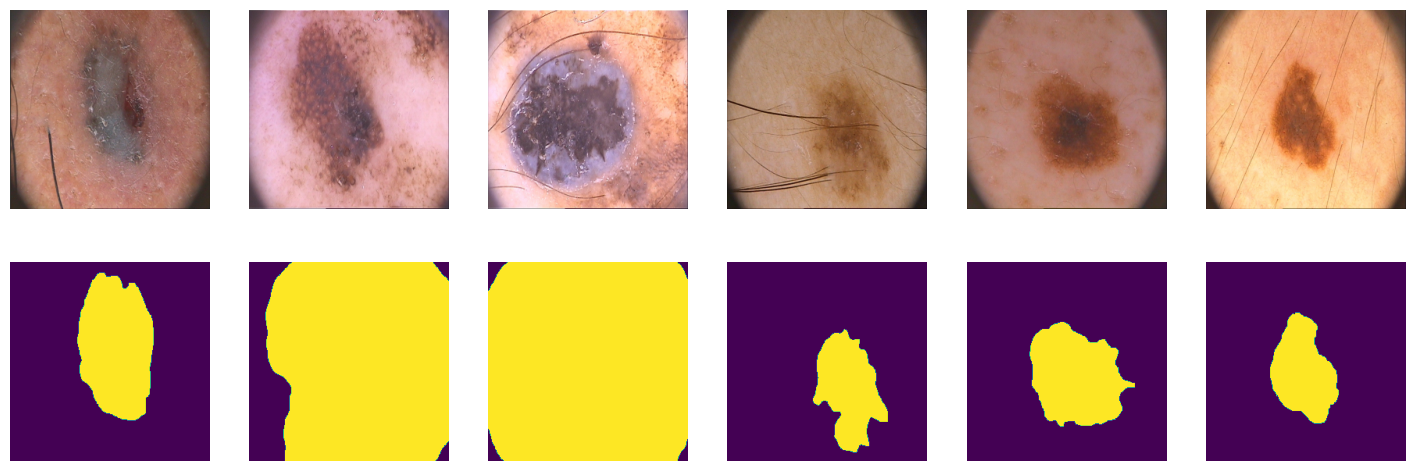

In [9]:

import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [10]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [11]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [12]:
from torch.utils.data import DataLoader
batch_size = 20
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [13]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

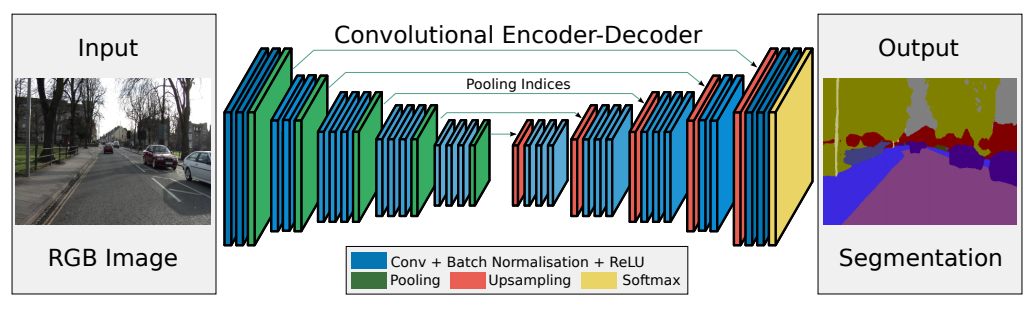

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [15]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        self.upsample_b = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_convb = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride=(1, 1), padding=(1, 1))
        )

    def forward(self, x):
        # encoder
        id = []
        e0, id0 = self.pool0(self.enc_conv0(x))
        id.append(id0)
        e1, id1 = self.pool1(self.enc_conv1(e0))
        id.append(id1)
        e2, id2 = self.pool2(self.enc_conv2(e1))
        id.append(id2)
        e3, id3 = self.pool3(self.enc_conv3(e2))
        id.append(id3)

        # bottleneck
        # b, id4 = self.pool4(self.bottleneck_conv(e3))
        # id.append(id4)
        # d_b = self.dec_convb(self.upsample_b(b, id[4]))

        # decoder

        d0 = self.dec_conv0(self.upsample0(e3, id[3]))
        d1 = self.dec_conv1(self.upsample1(d0, id[2]))
        d2 = self.dec_conv2(self.upsample2(d1, id[1]))
        d3 = self.dec_conv3(self.upsample3(d2, id[0]))   # no activation
        return (d3)

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    # outputs = outputs.byte()  # BATCH x 1 x H x W => BATCH x H x W
    # labels = labels.byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [17]:
def bce_loss(y_real, y_pred):
    # TODO
    # please don't use nn.BCELoss. write it from scratch
    loss = y_pred - y_real * y_pred + torch.log(torch.ones(1).to(device)+torch.exp(-y_pred))
    return torch.mean(loss).requires_grad_(True)

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [18]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch,Y_pred)
            loss.backward()  # backward-pass
            opt.step()  # update weights
            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = Y_pred.detach().cpu()# detach and put into cpu
        X_hat = X_batch.detach().cpu()
        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_hat[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [19]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [model(X_batch) for X_batch, _ in data]
    return np.array(Y_pred)

In [20]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device)).mean(1)
        scores += metric((torch.sigmoid(Y_pred) > 0.5), Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)

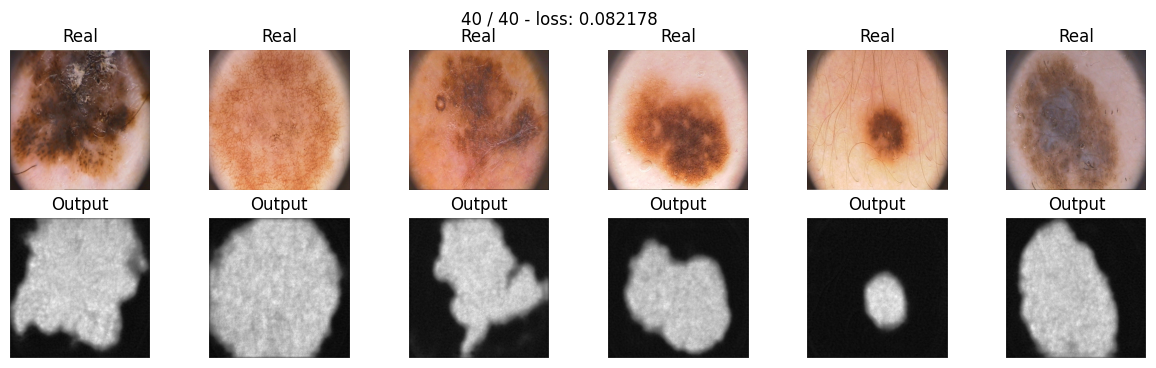

In [ ]:
max_epochs = 40
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
train(model, optim, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
# torch.save(model.state_dict(), '/content/drive/MyDrive/segnet.pth')
# model.load_state_dict(torch.load('/content/drive/MyDrive/segnet.pth'))

In [ ]:
score_model(model, iou_pytorch, data_tr)


0.9110000610351563

In [ ]:
score_model(model, iou_pytorch, data_val)


0.6266667048136393

Вывод: модель не переобучается, т.к. доля совпадающих пикселей примерно равна на обучающей и тестовой выборках


-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла]

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_loss(y_real, y_pred):

    smooth = 1e-8
    y_pred = F.sigmoid(y_pred)
    intersection = torch.sum((y_pred * y_real),dim=(2,3))*2
    union = torch.sum(y_pred,dim=(2,3))+torch.sum(y_real,dim=(2,3))
    res = ((intersection+smooth) / (union+smooth))
    loss = torch.ones_like(intersection) - res
    # return torch.tensor(torch.ones(1).to(device)-res/torch.tensor(256*256), requires_grad=True)
    return torch.mean(loss)

Проводим тестирование:

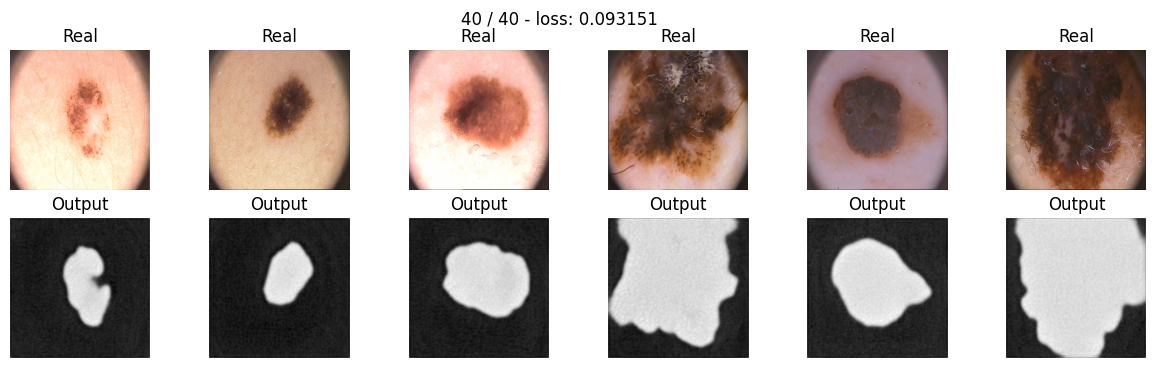

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=1e-4)
train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.7050000429153442

In [ ]:
score_model(model_dice, iou_pytorch, data_tr)

0.856000030040741

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [31]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):

    p = (torch.sigmoid(y_pred))
    p = torch.clamp(p, 1e-4, 1-1e-4)
    logp = torch.log(p)
    loss = ((1 - p) ** gamma) * y_real * torch.log(p)  + (1 - y_real) * torch.log(1-p)
    return -loss.sum()


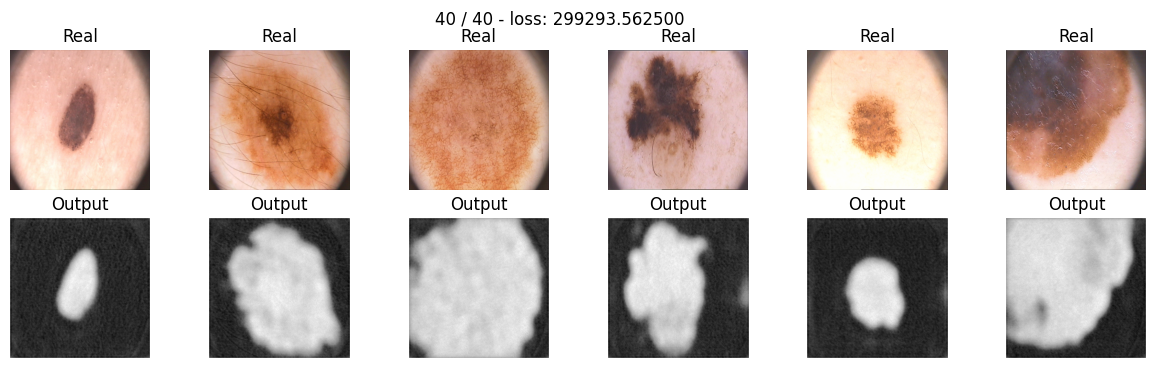

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 40
optimaizer = torch.optim.Adam(model_focal.parameters(), lr=1e-4)
train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)


0.6533333460489908

In [ ]:
score_model(model_focal, iou_pytorch, data_tr)

0.8040000319480896

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
# источник: https://github.com/PatRyg99/HausdorffLoss/blob/master/hausdorff_loss.py
from scipy.ndimage.morphology import distance_transform_edt as edt
@torch.no_grad()
def distance_field(img: np.ndarray) -> np.ndarray:
        field = np.zeros_like(img)

        for batch in range(len(img)):
            fg_mask = img[batch] > 0.5

            if fg_mask.any():
                bg_mask = ~fg_mask

                fg_dist = edt(fg_mask)
                bg_dist = edt(bg_mask)

                field[batch] = fg_dist + bg_dist

        return field

<ipython-input-36-8ea16c025512>:2: DeprecationWarning: Please use `distance_transform_edt` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import distance_transform_edt as edt


In [ ]:
# источник: https://github.com/PatRyg99/HausdorffLoss/blob/master/hausdorff_loss.py
def hausdorffloss(y_real, y_pred, alpha = 2):
    y_pred = F.sigmoid(y_pred)
    pred_error = (y_pred - y_real) ** 2

    pred_dt = torch.from_numpy(distance_field(y_pred.cpu().detach().numpy())).float()
    target_dt = torch.from_numpy(distance_field(y_real.cpu().detach().numpy())).float()
    distance = pred_dt ** alpha + target_dt ** alpha
    distance = distance.to(device)

    dt_field = pred_error * distance
    loss = dt_field.mean()
    return loss

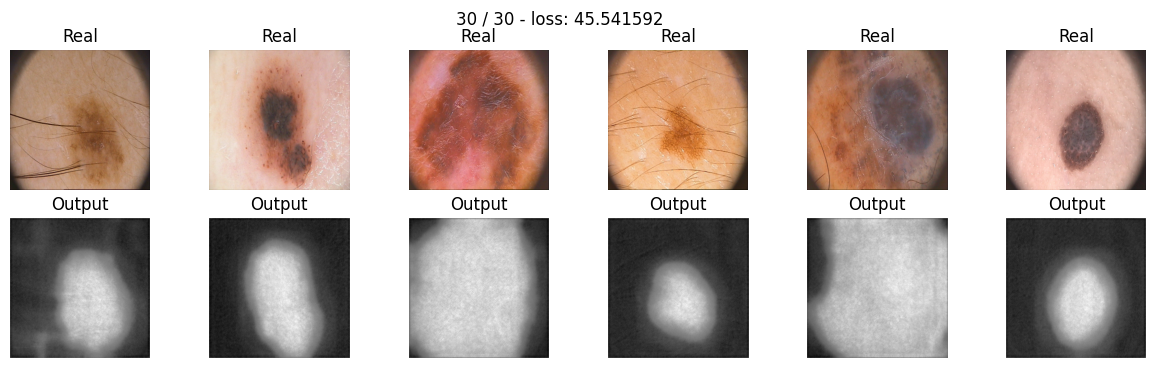

In [ ]:
model_hd = SegNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(model_hd.parameters(), lr=1e-4)
train(model_hd, optimaizer, hausdorffloss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_hd, iou_pytorch, data_val)

0.423333336909612

In [ ]:
score_model(model_hd, iou_pytorch, data_tr)

0.5560000240802765

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

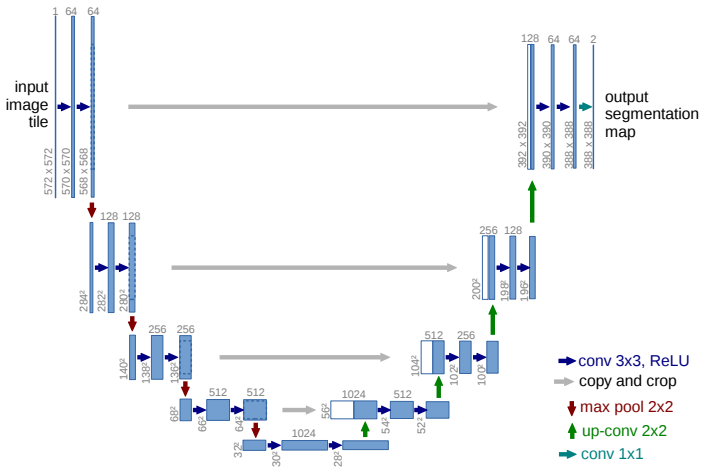

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [21]:
import torchvision

In [27]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.upsample_b = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_convb = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=(1, 1), padding=(1, 1))
        )
        # self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        # self.dec_conv3 = nn.Sequential(
        #     nn.Conv2d(128, 64, kernel_size=3, stride=(1, 1), padding=(1, 1)),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 2, kernel_size=3, stride=(1, 1), padding=(1, 1))
        # )


    def cat(self, x, fts):
        enc_ftrs = self.crop(fts, x)
        out = torch.cat([x, enc_ftrs], dim=1)
        return out

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

    def forward(self, x):
        # encoder
        features = []
        id = []
        e0, id0 = self.pool0(self.enc_conv0(x))
        features.append(e0)
        id.append(id0)
        e1, id1 = self.pool1(self.enc_conv1(e0))
        features.append(e1)
        id.append(id1)
        e2, id2 = self.pool2(self.enc_conv2(e1))
        features.append(e2)
        id.append(id2)
        e3, id3 = self.pool3(self.enc_conv3(e2))
        features.append(e3)
        id.append(id3)

        # bottleneck
        b = self.bottleneck_conv(e3)
        d_b = self.dec_convb(self.cat(self.upsample_b(b, id[-1]), features[-1]))

        # decoder

        d0 = self.dec_conv0(self.cat(self.upsample0(d_b, id[-2]), features[-2]))
        d1 = self.dec_conv1(self.cat(self.upsample1(d0, id[-3]),features[-3]))
        d2 = self.dec_conv2(self.cat(self.upsample2(d1, id[-4]), features[-4]))
        # no activation
        return (d2)


In [28]:

unet_model = UNet().to(device)

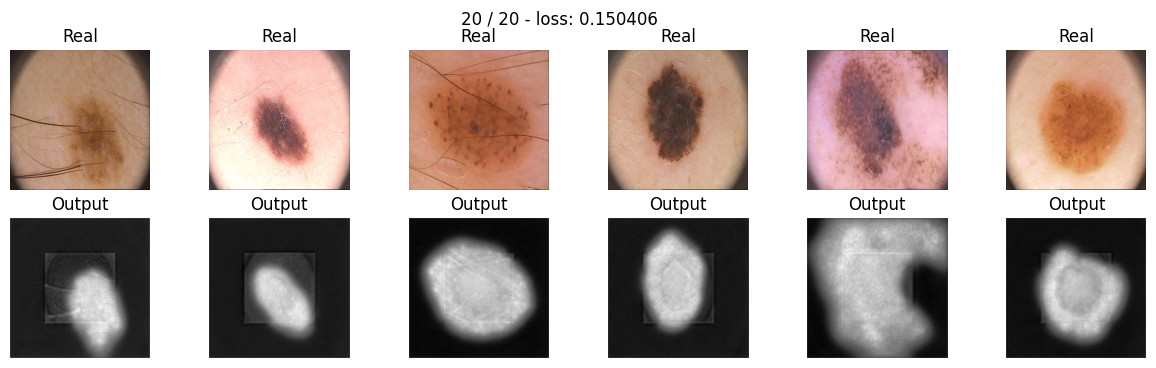

In [ ]:
train(unet_model, optim.Adam(unet_model.parameters(), lr=1e-4), bce_loss, 20, data_tr, data_val)

In [29]:
# torch.save(unet_model.state_dict(), '/content/drive/MyDrive/unet_model.pth')
unet_model.load_state_dict(torch.load('/content/drive/MyDrive/unet_model.pth'))

<All keys matched successfully>

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.6566666762034098

In [ ]:
score_model(unet_model, iou_pytorch, data_tr)

0.6830000281333923

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [22]:
class UNet2(nn.Module):

    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(64, 64, kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(128, 128, kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.Conv2d(256, 256, kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.Conv2d(512, 512, kernel_size=2, stride=2)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.upsample_b = nn.ConvTranspose2d(512, 512, 2, stride=2)
        self.dec_convb = nn.Sequential(
            nn.Conv2d(1024, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(256, 256, 2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(128, 128, 2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(64, 64, 2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, stride=(1, 1), padding=(1, 1))
        )
        # self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256
        # self.dec_conv3 = nn.Sequential(
        #     nn.Conv2d(128, 64, kernel_size=3, stride=(1, 1), padding=(1, 1)),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(),
        #     nn.Conv2d(64, 2, kernel_size=3, stride=(1, 1), padding=(1, 1))
        # )


    def cat(self, x, fts):
        enc_ftrs = self.crop(fts, x)
        out = torch.cat([x, enc_ftrs], dim=1)
        return out

    def crop(self, enc_ftrs, x):
        _, _, H, W = x.shape
        enc_ftrs = torchvision.transforms.CenterCrop([H, W])(enc_ftrs)
        return enc_ftrs

    def forward(self, x):
        # encoder
        features = []
        e0= self.pool0(self.enc_conv0(x))
        features.append(e0)
        e1 = self.pool1(self.enc_conv1(e0))
        features.append(e1)
        e2 = self.pool2(self.enc_conv2(e1))
        features.append(e2)
        e3 = self.pool3(self.enc_conv3(e2))
        features.append(e3)

        # bottleneck
        b = self.bottleneck_conv(e3)
        d_b = self.dec_convb(self.cat(self.upsample_b(b), features[-1]))

        # decoder

        d0 = self.dec_conv0(self.cat(self.upsample0(d_b), features[-2]))
        d1 = self.dec_conv1(self.cat(self.upsample1(d0),features[-3]))
        d2 = self.dec_conv2(self.cat(self.upsample2(d1), features[-4]))
        # no activation
        return (d2)

In [23]:
unet2_model = UNet2().to(device)


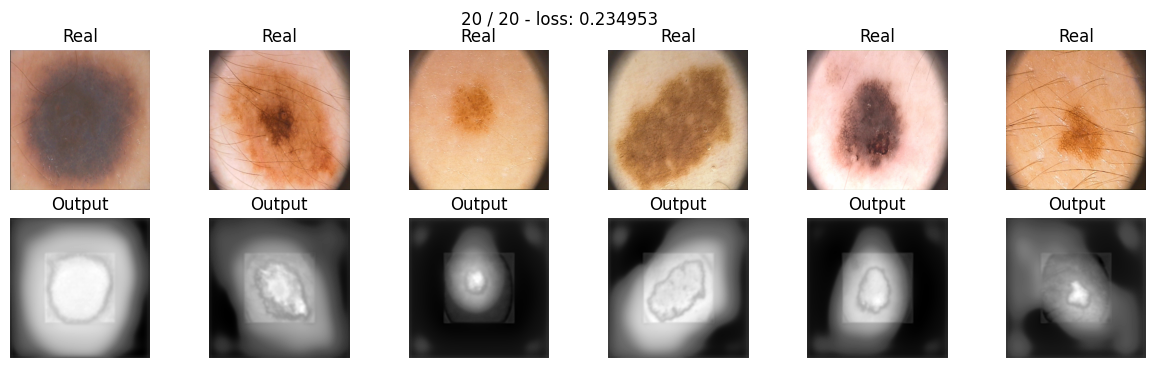

In [38]:
train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 20, data_tr, data_val)

In [24]:
# torch.save(unet2_model.state_dict(), '/content/drive/MyDrive/unet2_model.pth')
unet2_model.load_state_dict(torch.load('/content/drive/MyDrive/unet2_model.pth'))

<All keys matched successfully>

In [25]:
score_model(unet2_model, iou_pytorch, data_val)


0.46833332379659015

In [26]:
score_model(unet2_model, iou_pytorch, data_tr)

0.5000000357627868

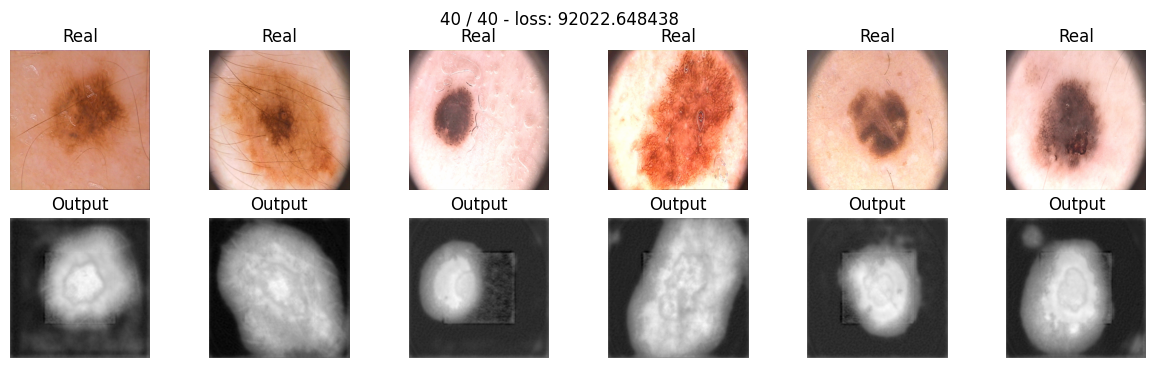

In [34]:
train(unet_model, optim.Adam(unet_model.parameters(), lr=1e-4), focal_loss, 40, data_tr, data_val)

In [35]:
torch.save(unet_model.state_dict(), '/content/drive/MyDrive/unet_model.pth')
unet_model.load_state_dict(torch.load('/content/drive/MyDrive/unet_model.pth'))

<All keys matched successfully>

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов):

В результате сравнения различных моделей сегментации с помощью IoU Loss наибольший результат получилось достичь с помощью SegNet с функцией потерь Dice Loss.

Unet модель показывает меньший результат по сравнению с SegNet. Возможно, это связано с ошибками в реализации модели.

Hausdorff Loss показывает наименьший результат на валидационно выборке, что может быть связано с небольшой глубиной фото.

SegNet сильнее переобучается на представленных лоссах, показывая при этом лучший результат по сравнению с Unet.